# Rapport de projet de session - IFT 712
### Objectif du projet : tester six méthodes de classification sur une base de données Kaggle.

Nous avons choisi la base de données "[Heart Failure Prediction Dataset][0]" puisqu'elle permet de faire de la classification sur un jeu de données réel et avec des applications concrètes. En effet, nous sommes tous les trois intéressés par le domaine de la santé et, bien que conscients que cette base de données allait demander légèrement plus de travail que la base conseillée, nous sommes partis dans cette direction.
Les méthodes de classification que nous allons tester sont les suivantes :
* Régression logistique
* K plus proches voisins
* SVM
* Réseau de neurones
* Forêt aléatoire
* Modèle Gaussien naïf

Pour cela, nous utiliserons la bibliothèque scikit-learn pour implémenter les algotihmes ainsi que pandas  pour traiter les données

Nous utiliserons également [Trello][1] ainsi que discord afin d'organiser le projet à haut niveau
Le code est versionné sur [Github][1] en suivant les conventions suivantes :
* conventionals [commits][3]
* merge requests sur master
* une branche par feature

Le code et les commentaires sont rédigés en francais et suivant la convention [pep8][4] au possible. Nous utiliserons la fonctionnalité "code with me" de pycharm permettant à plussieurs membres du groupe de coder sur le même projet en même temps

[0]: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
[1]: https://trello.com/b/U21MHLaj/projet-ift712-deadline-11-12-23
[2]: https://github.com/MorganChabaudENSSAT/projet_ift712
[3]: https://www.conventionalcommits.org/en/v1.0.0/
[4]: https://peps.python.org/pep-0008/

In [3]:
'''
 Imporation des bibliothèques python générales
'''
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import warnings

'''
 Imporation des bibliothèques spécifiques au devoir
'''
from modele.regression_logistique import RegressionLogistique
from modele.svm import Svm
from modele.reseau_neurones import Reseau_neurones
from modele.foret_aleatoire import foret_aleatoire
from modele.k_plus_proches_voisins import K_PP_voisins
from modele.bayes_gaussien_naif import bayes_gaussien_naif

'''
    Suppression des Future Warnings 
'''
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore')

In [4]:
# Importation des données
df = pd.read_csv('../donnees/heart.csv') # Dataframe contenant les données
features_names = df.columns
features_nbr = features_names.shape[0]
print(f"nombre de features dans le dataset : {features_nbr}")
# Visualisation des données pour mieux les comprendre
print(df.head())
print(df.dtypes)

nombre de features dans le dataset : 12
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG 

In [5]:
# A partir de cette visualisation primaire des données, on  remarque que certaines features ne sont pas numériques ce qui empêche de les utiliser telles quelles dans les algorithmes de classification.
# => On va donc devoir traiter ces valeurs en les encodant.
le = LabelEncoder()

data = df.copy(deep = True)

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])

# Les données sont mainteant toutes numériques et utilisables par les algorithmes de classification que nous mettrons en place
print(data)

categorical_features = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
numerical_features = [x for x in features_names if x not in categorical_features]
numerical_features = numerical_features[:-1]

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

A présent, on explore les données à l'aide de visualisations afin de mieux comprendre leur nature et détecter les features les plus caractéristiques ainsi que la nature des distributions des données afin, au besoin, de formuler des hypothèses nous permettant de mettre en oeuvre différents modèles.
On commence par visualiser la distribution de chaque feature.

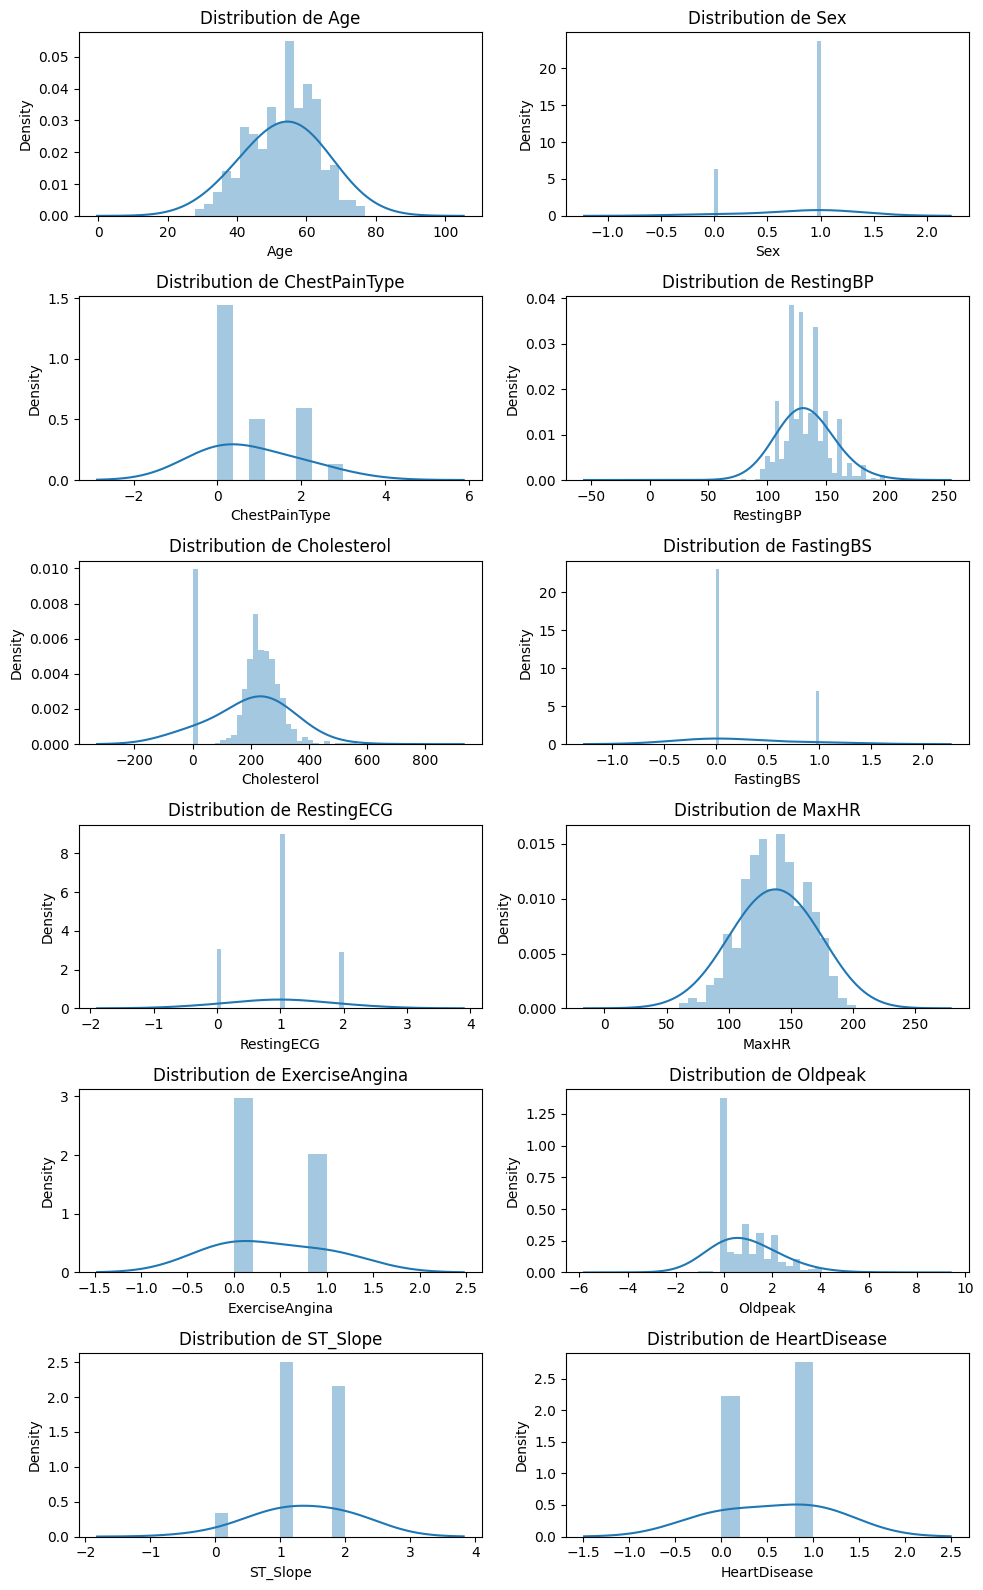

In [6]:
fig = plt.figure(figsize=(10,16))
for i in range(features_nbr):
    plt.subplot(int(features_nbr/2), 2, i+1)
    fig.tight_layout()
    cur_feature =features_names[i]
    sns.distplot(data[cur_feature], kde_kws={'bw' : 1})
    plt.title("Distribution de "+cur_feature)

## 1 - Régression logistique

In [7]:
# Création d'un modèle de base avec un pénalité l2 et un facteur de prise en compte de la pénalité de 1 centième
reg_log_naif=RegressionLogistique(data, features_names, features_nbr)

On met à l'echelle les données afin de réduire l'impact des différentes valeurs que peuvent prendre les données sur la précision du modèle.
On normalise et standardise toutes les données numériques.

In [8]:
# Mise à echelle des données
scaled_data = reg_log_naif.scale_data(numerical_features,numerical_features)

On peut alors récupérer les ensembles d'entrainement et de test et procéder à l'entraînement du modèle.

In [9]:
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = reg_log_naif.split_data(scaled_data)
# Entraînement du modèle sur les données d'entraînement
reg_log_naif.train(X_train, y_train)

On commence par évaluer la capacité d'apprentissage du modèle en appliquant un algorithme de cross validation stratifié.

In [10]:
reg_log_naif.K_fold(X_train,y_train)

Le score de cross-validation du modèle est:  0.848741206960385


Le score de cross-validation du modèle est:  0.848741206960385


On évalue le modèle sur les données de test.

Précision du modèle : 0.8586956521739131


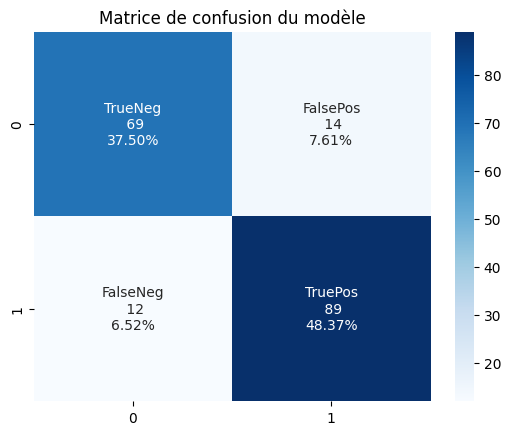

In [11]:
# Evaluation du modèle sur les données de test
reg_log_naif.evaluate_model(X_test,y_test)

On constate que les score de cross-validation et d'accuracy sont a peu près les même : 85%
Cela laisse penser que le modèle ne sur apprend pas les données.
On vérifie cela rapidmeent en évaluant le modèle sur l'ensemble d'entraînement

Précision du modèle : 0.8583106267029973

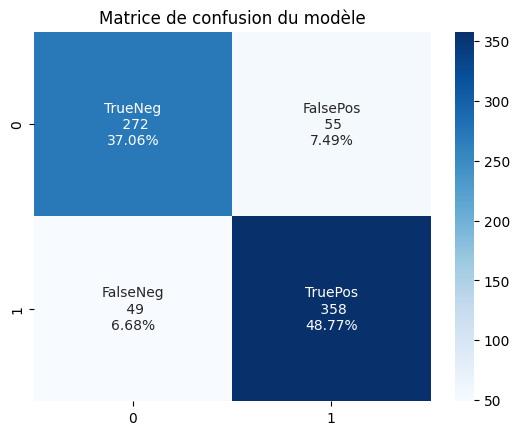

In [12]:
reg_log_naif.evaluate_model(X_train, y_train)

La remarque précédente es validée : il n'y a pas de sur apprentissage.
On va donc cherche maintenant à augmenter la capacité du modèle.

### Recherche d'un modèle de plus grande capacité ###
On cheche a présent à obtenir un modèle de plus grande qualité. Pour cela, on va comparer plusieurs régressions logistiques initialisées avec des hyperparamètres dfférents afin d'obtenir la combinaison optimal des hyperparamètres.
D'après le site de la bibliothèque sklearn, les hyperparamètres sur lesquels il est le plus important d'influer dans le cadre de la régression logistique et que nous étudierons en conséquence sont les suivants:
- le 'solver' c'est à dire l'algorithme d'optimisation qui minimise la loss
- 'penalty' qui correspond à la norme employée dans le terme de régularisation
- 'C' est la constante qui régule l'impact du terme de régularisation (c'est l'inverse de la force de régularisation)

Par la suite, on cherche donc a analyser les résultats des différentes combinaisons d'hyperparamètres de sorte à maximiser la capacité du système **tout en** l'empêchant d'overfitter sur les données. Pour cela, on visualisera l'évolution de l'accuracy sur les ensembles d'entraînement et de validation en procédant à une recherche d'hyperparamètres de type 'grid-search' reposant sur la 'cross_validation'.


In [13]:
config_1 = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'penalty' : ['l2'],
    'C' : np.logspace(-4,4,40)
}

config_2 = {
    'solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'],
    'penalty' : ['none'],
    'C' : np.logspace(-4,4,30)
}

config_3 = {
    'solver' : ['liblinear', 'saga'],
    'penalty' : ['l1'],
    'C' : np.logspace(-4,4,30)
}

config_4 = {
    'solver' : ['saga'],
    'penalty' : ['elasticnet'],
    'l1_ratio' : np.linspace(0,1,20),
    'C' : np.logspace(-4,4,30)
}

h_parameters_to_tune =[config_1, config_2, config_3, config_4]


In [14]:
post_grid_search_estimator = reg_log_naif.hyper_parameters_search(X_train, y_train, h_parameters_to_tune)

0.8542540303792749  pour les hyperparamètres suivants :  {'C': 0.38566204211634725, 'l1_ratio': 0.7368421052631579, 'penalty': 'elasticnet', 'solver': 'saga'}


Malgré la recherche d'hyperparamètre par grid-search, on trouve un modèle qui présente moins d'accuracy sur les données que le modèle naïf.
Cela peut être dû a une exploration trop peu exhaustive des configurations d'hyperparamètres possibles
On procède tout de même à l'évaluation de ce modèle.

In [15]:
reg_log_2 = RegressionLogistique(scaled_data, features_names, features_nbr, post_grid_search_estimator)

Précision du modèle : 0.8532608695652174


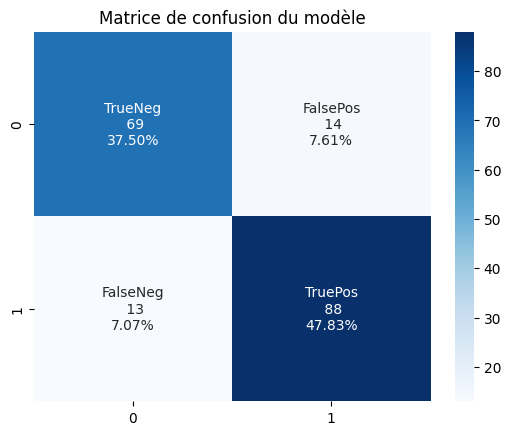

In [16]:
reg_log_2.evaluate_model(X_test, y_test)

In [17]:
reg_log_2.K_fold(X_train,y_train)

Le score de cross-validation du modèle est:  0.850999629766753


#### Amélioration du modèle : Nombre de données

On trace les courbes d'entraînement et de validation en fonction du nombre de données.

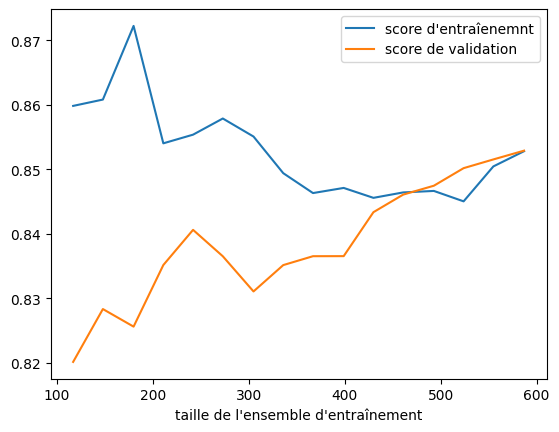

In [18]:
train_size = np.linspace(0.2,1,16)
reg_log_2.data_needed_for_max_score(X_train, y_train, train_size)

On constate que le modèle stagne sur l'entraînement. Cependant, la validation augmente bien avec le nombre de données. Cela semble indiquer que les paramètres choisis pour la régression logistique ne sont pas optimaux.
Or, la recherche d'hyperparamètres permet de trouver les paramètres optimaux donc on peut supposer que les données ne sont pas assez explicite. il faudrait donc retravailler sur les données avec des outils de préprocessing.

#### Conclusion sur le modèle de régression logistique

Nous avons construit un modèle de régression logistique permettant de classifier avec environ 85% de précision les données.
Toutefois, un nombre de données accru ainsi qu'un pré processing des données plus poussé (utilisant par exemple une matrice de correlation permettant de distinguer les features les plus importantes) est une piste d'amélioration pour le modèle.

## 2 - K plus proches voisins

Dans cette partie, on classifie les données à l'aide du classifieur par K plus proches voisins.
Nous évaluerons la valeur de l'hyperparamètre K à l'aide d'une recherche de type 'grid-search' utilisant une 'stratified-cross-validation'

On commence par initialiser un classifieur dit 'naïf' avec l'hyperparamètre K=5 afin d'avoir une base sur laquelle travailler.

In [19]:
# Instantiation du modèle avec K =5
knn_model_naif =  K_PP_voisins(data, features_names, features_nbr)

On entraîne le modèle sur les données non traitées

Précision du modèle : 0.7010869565217391


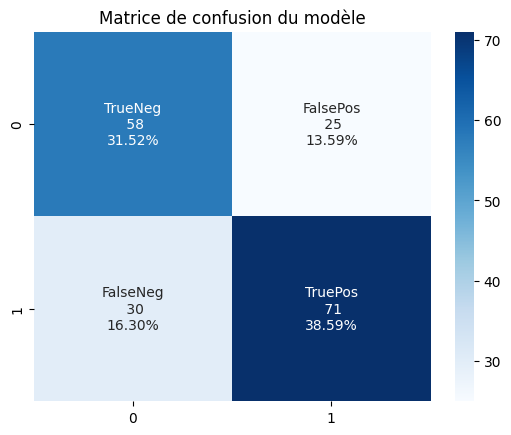

In [20]:
# Génération des ensembles d'entrainement et de test
X_train, X_test, y_train, y_test = knn_model_naif.split_data(data)
# Entraînement du modèle sur les données X_train et y_train
knn_model_naif.train(X_train, y_train)
# Evaluation du modèle
knn_model_naif.evaluate_model(X_test,y_test)

Le modèle a une accuracy de 70%, ce qui semble assez faible. Cela est bien sûr causé par l'utilisation du modèle sur des données non transformées.

On normalise puis standardise les données numériques afin de comparer le gain d'accuracy entre les deux modèles.

In [21]:
# Normalisation des données numériques
scaled_data_knn = knn_model_naif.scale_data(numerical_features,numerical_features)

On Visualise les données afin de nous assurer que les opérations ont été réalisées avec succès

In [22]:
print(data)
print(scaled_data_knn)

     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  Hear

On peut alors entraîner le modèle de classification par K plus proches voisins sur les données transformées

In [23]:
# Instantiation du modèle avec K =5
knn_model_naif_2 =  K_PP_voisins(data, features_names, features_nbr)
# Génération des ensembles d'entrainement et de test a partir des données transformées
X_train, X_test, y_train, y_test = knn_model_naif_2.split_data(scaled_data_knn)
# Entraînement du modèle sur les données X_train et y_train
knn_model_naif_2.train(X_train, y_train)

On évalue la capacité du modèle à apprendre les données d'entraînement à l'aide de 'stratified-cross-validation'. Les données sur lesquelles est entrainé le modèle sont séparées en un ensemble d'entraînement et de validation permettant d'évaluer la capacité à généraliser du modèle. On évalue le score sur chaque fold puis on en prend la moyenne afin d'obtenir la meilleure évaluation de l'accuracy possible

In [24]:
knn_model_naif_2.K_fold(X_train,y_train)

Le score de cross-validation du modèle est:  0.8469394051585831


On évalue à présent le modèle sur les données de test.

Précision du modèle : 0.8206521739130435


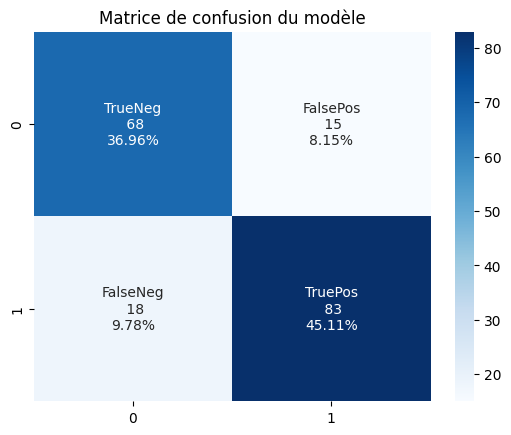

In [25]:
# Evaluation du modèle sur les données de test
knn_model_naif_2.evaluate_model(X_test, y_test)

Le modèle arrive à prédire correctement l'existence ou l'absence de maladie cardiaque dans environ 82% des cas sur les données de tests.
On constate une forte augmentation de l'accuracy du modèle par rapport au premier grâce au pré-traitement effectué sur les données.

#### Amélioration du modèle : recherche des hyperparamètres

L'analyse de base du classifieur étant établie, on procède maintenant à une recherche d'hyperparamètres. D'après la documentation de [sklearn][1] les hyperparamètres du modèles sont les suivants :
- n_neighbors : le nombre de voisins nécesaires pour la classification du point courant
- weights : La métrique utilisée pour prédire l'appartenance d'un point à une classe ou à une autre
- algorithm : algorithme utilisé pour le calcul
- leaf_size : nombre de points à partir duquel l'algorithme choisi les voisins en force brute
- p : puissance dans la distance de Minkowski indiquant la nature de la mesure
- metric : la métrique utilisée

On conserve la métrique de base (Minkowski) car le choix de la valeur de p permet de choisir la métrique indirectement.
Le jeu de données étant inférieur à 1000 points, on peut utiliser l'approche par force brute directement car le temps de calcul devrait rester raisonnable. Ainsi, on fixe leaf_size à 1.
L'algorithme utilisé pour le calcul des plus proches voisins est laissé à 'auto'.

Il nous reste donc à calculer les valeurs d'hyperparmètres suivants:
- n_neighbors
- weights
- p

On utilise une recherche d'hyperparamètres de type grid-search. Pour cela, on instancie un dictionnaire contenant les couples (noms du paramètres : valeurs prises par ce paramètre)

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [26]:
n_neighbors_values = np.linspace(1,20,20).astype(int) # valeurs prises par l'hyperparamètre n_neighbors
weights_values = ['uniform', 'distance']    # valeurs prises par l'hyperparamètre weights
p_values = np.linspace(1,10,10).astype(int) # valeurs prises par l'hyperparamètre p
h_parameters_to_tune ={
    'n_neighbors' : n_neighbors_values,
    'weights' : weights_values,
    'p' : p_values
}
other_parameters=['leaf-size=1','metric=minkowski']

In [27]:
knn_post_grid_search_estimator = knn_model_naif.hyper_parameters_search(X_train, y_train, h_parameters_to_tune, other_parameters)

0.8706178361755661  pour les hyperparamètres suivants :  {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


On constate une amélioration du score de cross-validation d'environ 2.5%

On intancie maintenant un nouveau classifieur avec les hyperparamètres que nous venons de trouver puis nous l'évaluons sur les données de test 

Précision du modèle : 0.8641304347826086


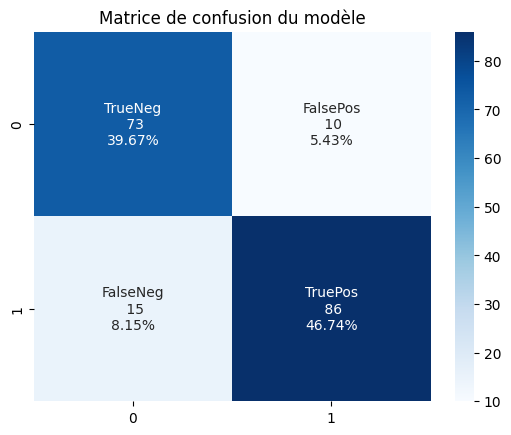

In [28]:
# instanciation du classifieur unitilisant les hyperparamètres trouvés
knn_2=K_PP_voisins(data, features_names, features_nbr,knn_post_grid_search_estimator)
# Evaluation
knn_2.evaluate_model(X_test, y_test)

L'accuracy du modèle s'est améliorée de presque 5% grâce au choix d'hyperparamètres que nous avons fait.

Afin d'améliorer davantage le modèle, on étudie les interactions entre le modèle et les données

#### Amélioration du modèle : nombre de données

A présent, on étudie le nombre de données nécessaire dans l'ensemble d'entraînement afin de favoriser l'apprentissage du modèle. Pour cela, on va évaluer la performance du modèle sur plusieurs ensembles d'entraînement dont les tailles sont différentes et afficher les résultats obtenus sous la forme de graphiques.
Afin de valider la capacité à généraliser du modèle, nous visualiserons également le score obtenu sur l'ensemble des données de validation.

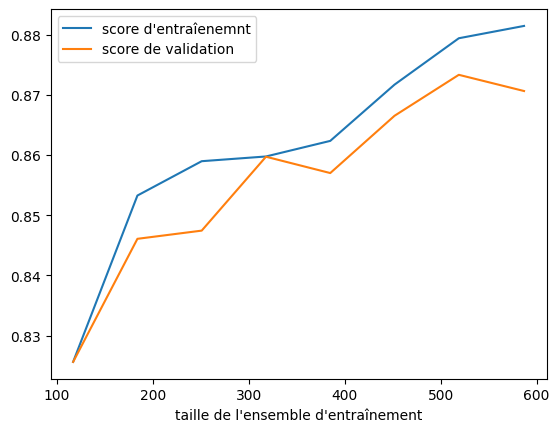

In [29]:
train_size = np.linspace(0.2,1,8)
knn_2.data_needed_for_max_score(X_train, y_train, train_size)

Ce graphique indique que la valeur d'accuracy représentée par les courbes d'apprentissage et de validation semble augmenter avec le nombre de données ce qui indique que le modèle n'est pas au bout de son apprentissage. Ainsi, si nous disposions de plus de données, nous pourrions rendre le modèle encore plus performant.

#### Conclusion sur le modèle des K plus proches voisins

Le modèle des K plus proches voisins a permis d'obtenir une accuracy de plus de **86%** sur l'ensemble de test aevc les hyperparamètres suivants : **{'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}** ce qui constitue un gain d'environ 16% par rapport au modèle naïf.
Nous avons observé que **le modèle pourrait gagner en accuracy en bénéficiant de plus de données lors de l'entraînement**.

## 3 - Machine à Vecteurs de Support ##

Pour la classification à l'aide de SVM, nous allons vérifier les performances des différents types de noyaux, afin de trouver le meilleur modèle possible.
Dépendemment du type de noyau utilisé, nous tenterons d'optimiser les hyper-paramètres de chaque modèle afin de trouver le meilleur modèle pour chaque noyau, puis nous comparerons les résultats.
### 3.1 - SVM à noyau linéaire
Dans le cas du noyau linéaire, il n'existe pas d'hyperparamètres à optimiser comme indiqué dans la documentation sklearn de la classe Support Vector Classification.

Précision du modèle : 0.8641304347826086


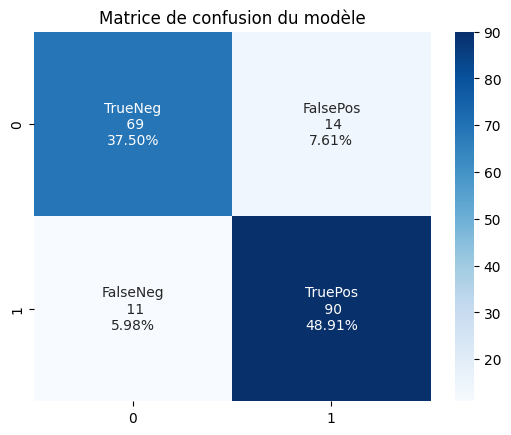

In [30]:
# Création du modèle avec noyau linéaire
linear_svm_instance = Svm(data, features_names, features_nbr, model='linear')
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = linear_svm_instance.split_data(data)
# Entraînement du modèle sur les données d'entraînement
linear_svm_instance.train(X_train, y_train)
# Evaluation du modèle
linear_svm_instance.evaluate_model(X_test,y_test, confusion_matrix=True)

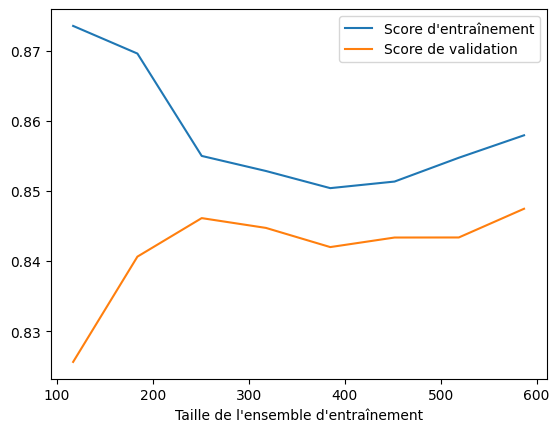

In [33]:
train_size = np.linspace(0.2, 1, 8)
linear_svm_instance.plot_learning_curves(X_train, y_train, train_size)

Le fait que les courbes de score évoluent sensiblement de la même façon à partir d'une taille de 350 indique que l'ajustement est relativement approprié.

### 3.1 - SVM à noyau Radial Basis Function
On s'intéresse maintenant à la classification par machines à vecteurs de support avec un noyau RBF. Dans ce cas, les paramètres optimisables sont gamma et C.
Le paramètre C équilibre la classification incorrecte des exemples d'entraînement par rapport à la simplicité de la surface de décision.Plus C est grand, plus le modèle risque le sur-apprentissage. Le paramètre gamma définit l'influence qu'a un exemple d'entraînement unique, et donc plus gamma est grand, plus les autres exemples doivent être proches pour être affectés. Observons d'abord le résultat brut de classification sans optimisation des hyper-paramètres du modèle à noyau RBF.

Précision du modèle : 0.7119565217391305


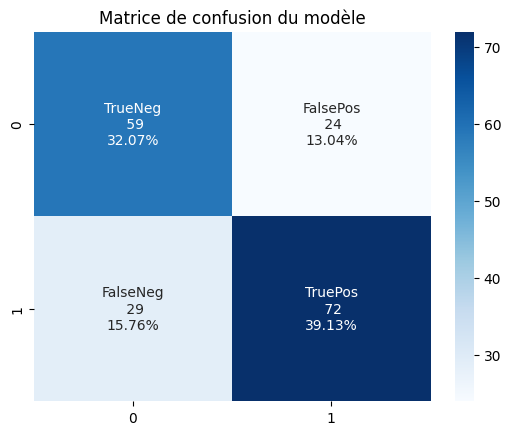

In [34]:
# Création du modèle avec noyau rbf
rbf_svm_instance = Svm(data, features_names, features_nbr, model='rbf')
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = rbf_svm_instance.split_data(data)
# Entraînement du modèle sur les données d'entraînement
rbf_svm_instance.train(X_train, y_train)
# Evaluation du modèle
rbf_svm_instance.evaluate_model(X_test,y_test)

Observons les scores d'entraînement et de validation avant optimisation.

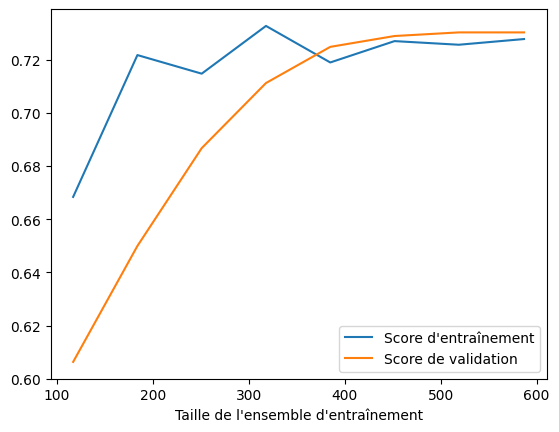

In [35]:
rbf_svm_instance.plot_learning_curves(X_train, y_train, train_size)

On va maintenant tenter d'optimiser les paramères gamma et C à l'aide d'un GridSearch de sorte à obtenir le meilleur modèle possible. Ces paramètres sont cruciaux pour la performance des SVM.

0.819047619047619  pour les hyperparamètres suivants, noyau RBF :  {'C': 100, 'gamma': 0.0001}
Précision du modèle : 0.842391304347826


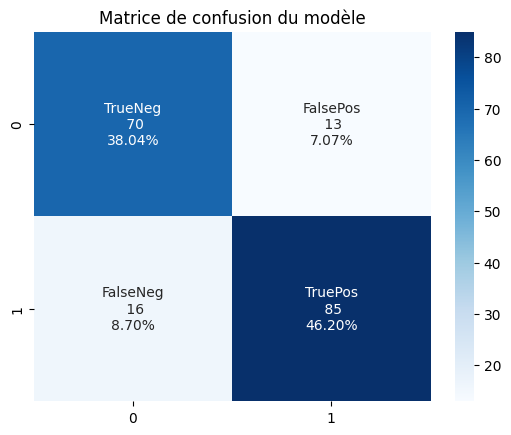

In [36]:
rbf_svm_best_estimator_post_grid = rbf_svm_instance.hyper_parameters_search(X_train, y_train)
best_rbf_svm = Svm(data, features_names, features_nbr, rbf_svm_best_estimator_post_grid)
best_rbf_svm.evaluate_model(X_test, y_test)

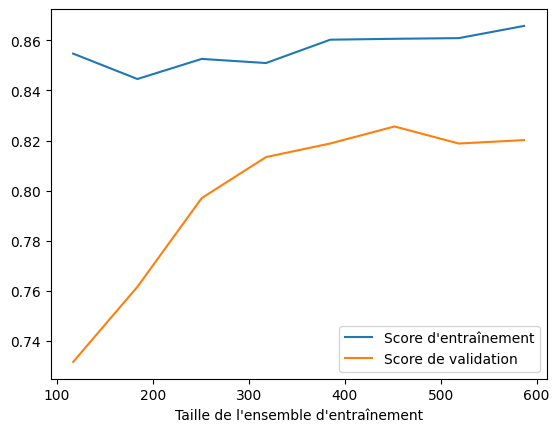

In [37]:
best_rbf_svm.plot_learning_curves(X_train, y_train, train_size)

On remarque que la précision du modèle est la même après optimisation des paramètres. Les courbes de score sont également les mêmes. On aurait pu s'abstenir d'optimiser le paramètre C, comme indiqué dans la documentation sklearn. En effet, il est conseillé de ne pas modifier la valeur de C sauf si les données sont très bruitées.

### 3.3 - SVM à noyau sigmoïde
On s'intéresse maintenant à la classification par machines à vecteurs de support avec un noyau sigmoide. Dans ce cas, le paramètre optimisable est coef0. On observe d'abord le résultat sans optimisation des paramètres.

Précision du modèle : 0.46195652173913043


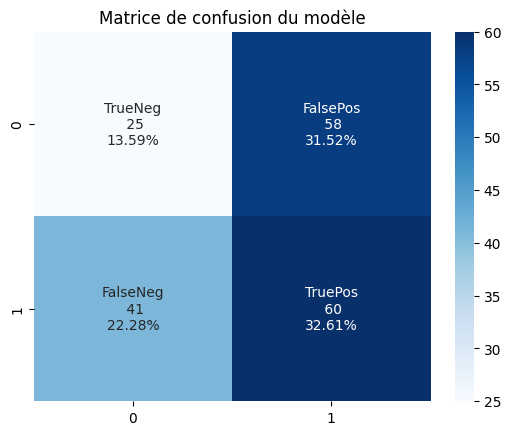

In [38]:
# Création du modèle avec noyau sigmoid
sigmoid_svm_instance = Svm(data, features_names, features_nbr, model='sigmoid')
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = sigmoid_svm_instance.split_data(data)
# Entraînement du modèle sur les données d'entraînement
sigmoid_svm_instance.train(X_train, y_train)
# Evaluation du modèle
sigmoid_svm_instance.evaluate_model(X_test,y_test)

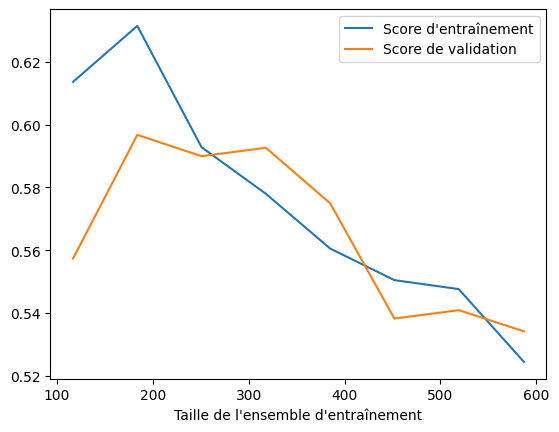

In [39]:
sigmoid_svm_instance.plot_learning_curves(X_train, y_train, train_size)

Les deux courbes de score baissent drastiquement. Cela peut indiquer que le modèle n'est pas bien spécifié ou encore que les données sont mal prétraitées. Essayons d'optimiser les hyper-paramètres afin d'améliorer le fonctionnement du modèle.

0.6693877551020407  pour les hyperparamètres suivants, noyau sigmoïde :  {'coef0': -3}
Précision du modèle : 0.6195652173913043


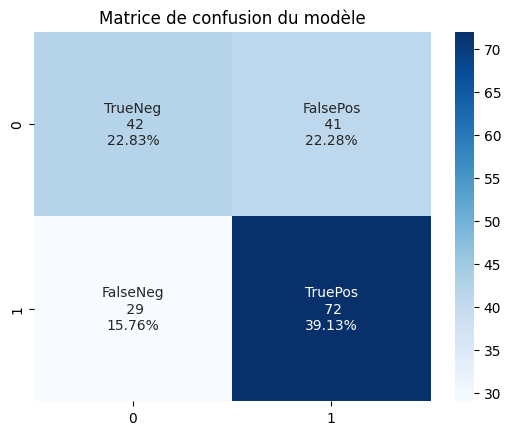

In [40]:
sigmoid_svm_best_estimator_post_grid = sigmoid_svm_instance.hyper_parameters_search(X_train, y_train)
best_sigmoid_svm = Svm(data, features_names, features_nbr, sigmoid_svm_best_estimator_post_grid)
best_sigmoid_svm.evaluate_model(X_test, y_test)

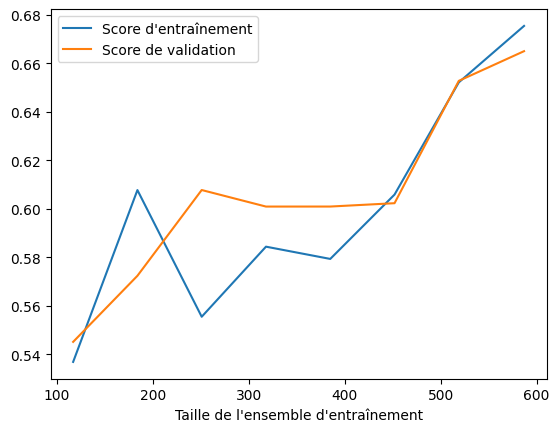

In [41]:
best_sigmoid_svm.plot_learning_curves(X_train, y_train, train_size)

On constate une nette amélioration du modèle de 8%, ainsi que de bien meilleures courbes de score. En effet, les courbes suivent à peu près la même évolution, indiquant que les ajustements sont plutôt corrects.

### 3.4 - SVM à noyau poly
Pour le dernier noyau étudié dans le cadre de ce projet, à savoir le noyau polynomial, celui-ci peut-être optimisé par les hyper-paramètres degree et coef0. Observons les résultats du modèle avant de tenter d'optimiser les paramètres à l'aide d'un GridSearch.

Précision du modèle : 0.6847826086956522


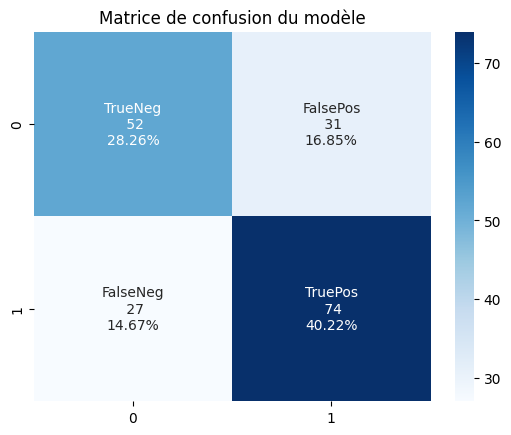

In [42]:
# Création du modèle avec noyau poly
poly_svm_instance = Svm(data, features_names, features_nbr, model='poly')
# Récupération des ensembles d'entraînements et de validation
X_train, X_test, y_train, y_test = poly_svm_instance.split_data(data)
# Entraînement du modèle sur les données d'entraînement
poly_svm_instance.train(X_train, y_train)
# Evaluation du modèle
poly_svm_instance.evaluate_model(X_test,y_test)

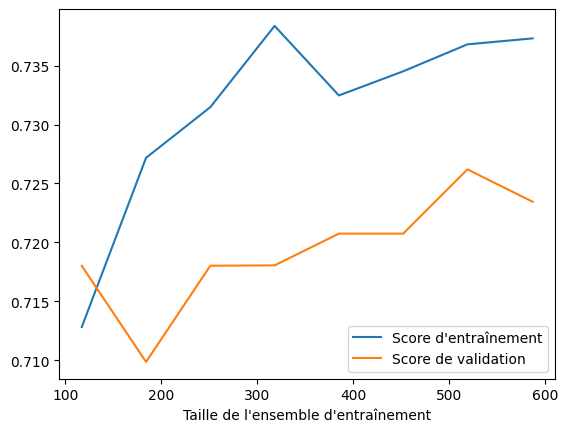

In [43]:
poly_svm_instance.plot_learning_curves(X_train, y_train, train_size)

Les courbes de score des modèles ne sont pas très bonnes. En effet, l'effet "dent-de-scie" observé sur la courbe du score de validation indique que le modèle sur-apprend. Passons à l'optimisation des hyper-paramètres du modèle.

0.8299319727891156  pour les hyperparamètres suivants, noyau polynomial :  {'coef0': 1, 'degree': 7}
Précision du modèle : 0.8369565217391305


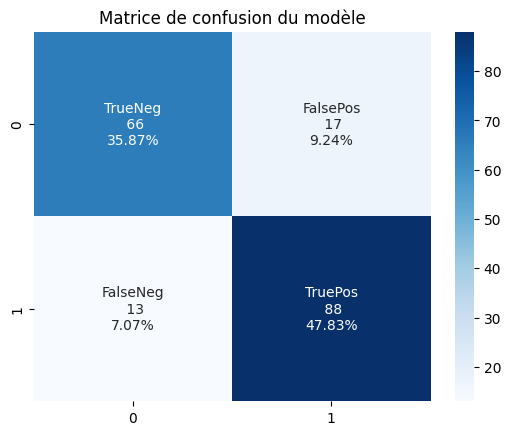

In [44]:
poly_svm_best_estimator_post_grid = poly_svm_instance.hyper_parameters_search(X_train, y_train)
best_poly_svm = Svm(data, features_names, features_nbr, poly_svm_best_estimator_post_grid)
best_poly_svm.evaluate_model(X_test, y_test)

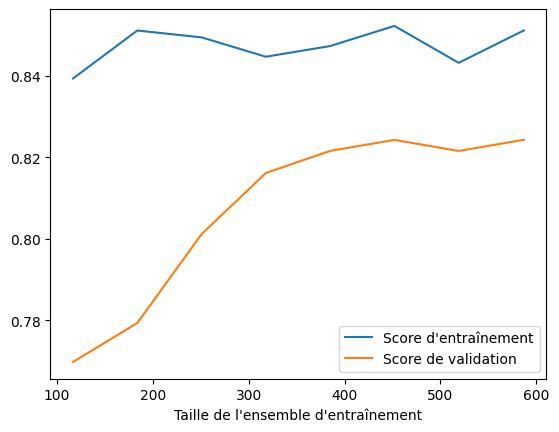

In [45]:
best_poly_svm.plot_learning_curves(X_train, y_train, train_size)

L'amélioration du modèle est faible (1%) après optimisation des hyper-paramètres, et ceci est vérifié par la visualisation des scores qui est sensiblement la même qu'avant optimisation des hyper-paramètres.

### 3.5 - Comparaison des noyaux
Après étude des modèles en fonction des noyaux et optimisation des hyper-paramètres, on remarque que les modèles qui ont la meilleure précision sont les modèles à noyaux rbf et polynomial. Pour autant, la classification par noyau polynomial semble plus prometteuse car les scores d'entraînement et de validation stagnent au fur et à mesure que la taille de l'ensemble d'entraînement augmente.

## 4 - Classification par réseau de neurones
Cette partie est consacrée à l'étude de la classification à l'aide de réseau de neurones. On utilise la classe définie par la bibliothèque sklearn nomée MLPClassifier.
Avant de pouvoir utiliser le modèle, nous devons standardiser et normaliser les données. Nous utiliserons les classes Min-Max-Scaler et StandardScaler de la bibliothèque sklearn.

Précision du modèle : 0.8478260869565217


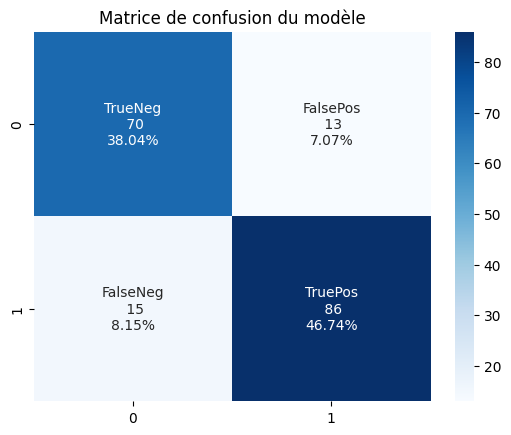

In [46]:
# Création d'une instance du modèle
neural_network = Reseau_neurones(data, features_names, features_nbr)
features_to_standardise = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
features_to_normalise = features_names
scaled_data = neural_network.scale_data(features_to_normalise=features_to_normalise, features_to_standardise=features_to_standardise)
X_train, X_test, y_train, y_test = neural_network.split_data(scaled_data)
neural_network.train(X_train, y_train)
neural_network.evaluate_model(X_test,y_test)

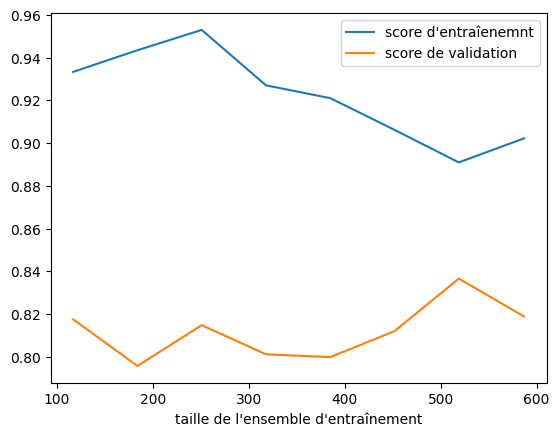

In [47]:
train_size = np.linspace(0.2, 1, 8)
neural_network.plot_learning_curves(X_train, y_train, train_size)

On remarque que le modèle voit son score d'entraînement diminuer drastiquement lorsque la taille de l'ensemble d'entraînement augmente, tandis que la courbe qui retrace le score de validation augmente. Le modèle a donc tendance à sur-apprendre quand la taille de l'ensemble d'entraînement croît. On cherche à optimiser les hyper-paramètres, ce que l'on va réaliser à l'aide d'un GridSearch.

0.8501723977262138  pour les hyperparamètres suivants :  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (10,), 'max_iter': 500, 'solver': 'adam'}
Précision du modèle : 0.875


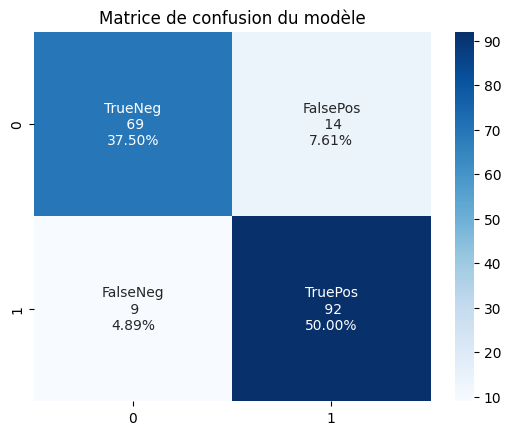

In [48]:
neural_network_best_estimator_post_grid = neural_network.hyper_parameters_search(X_train, y_train)
best_neural_network = Reseau_neurones(scaled_data, features_names, features_nbr, neural_network_best_estimator_post_grid)
best_neural_network.train(X_train,y_train)
best_neural_network.evaluate_model(X_test, y_test)

On constate une amélioration d'environ 3% de la précision du modèle après optimisation des hyper-paramètres.
Observons l'apprentissage du réseau de neurones bien paramétré à l'aide de la méthode partial_fit de la classe MLPClassifier de sklearn.

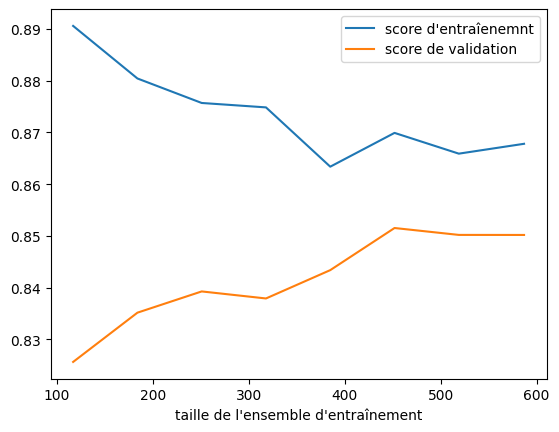

In [49]:
best_neural_network.plot_learning_curves(X_train, y_train, train_size)

Il semble qu'à partir d'un échantillon de 450 données, le modèle dont les hyper-paramètres sont les meilleurs a tendance a moins sur-apprendre.

## 5 - Forêt aléatoire
Dans cette section, l'algorithme de forêt aléatoire est mis en oeuvre. Ce modèle construit un ensemble d'arbres de décision, chacun formé sur un échantillon aléatoire des données d'entraînement. Lors de la prédiction, chaque arbre propose un résultat, et le vote majoritaire dans la forêt est sélectionné. Ce procédé permet de réduire les chances de surapprentissage.

### Création d'une instance du modèle de forêt aléatoire
Nous commençons par créer une instance de la classe foret_aleatoire, qui hérite des fonctionnalités de la classe abstraite Modele. L'algorithme de forêt aléatoire est instancié avec le critère de division des arbres défini sur "log_loss", en utilisant une graine aléatoire pour pouvoir reconduire les expériences.

In [50]:
# Création d'une instance du modèle de forêt aléatoire
seed = 42
np.random.seed(seed)
forest = foret_aleatoire(data=data, features_names=features_names, features_nbr=features_nbr, model=RandomForestClassifier(criterion='log_loss', random_state=seed))

### Entrainement et évaluation du modèle
La structure de forêt d'arbres étant invariante par changement d'échelle, il n'est pas nécessaire de normaliser les données. En outre, la décision par majorité de votes permet de réduire l'influence des valeurs extremales, ce qui explique que standardiser les données n'est pas requis. Les données sont donc séparées telles quelles pour créer les ensembles d'entrainement et de test.

In [51]:
# Récupération des ensembles d'entraînement et de validation
X_train, X_test, y_train, y_test = forest.split_data(data)

Le modèle est alors entraîné à l'aide de l'ensemble d'entrainement, puis évalué à l'aide de l'ensemble de test.

Précision du modèle : 0.8804347826086957


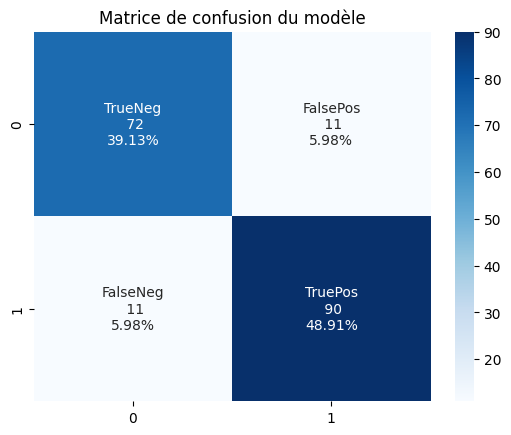

In [55]:
# Entraînement du modèle avec l'ensemble d'entraînement
forest.train(X_train, y_train)
# Evaluation du modèle avec l'ensemble de test
forest.evaluate_model(X_test,y_test)

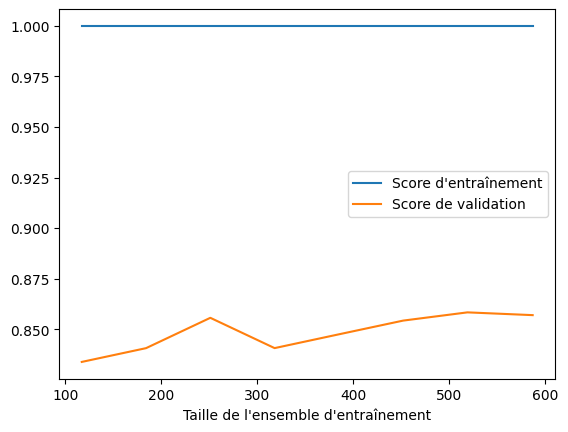

In [56]:
train_size = np.linspace(0.2, 1, 8)
forest.plot_learning_curves(X_train, y_train, train_size)

Les résultats obtenus sont présentés sous la forme d'une matrice de confusion, qui permet de visualiser les prédictions correctes et incorrectes du modèle. Le modèle de forêt aléatoire permet donc d'obtenir une précision d'environ 88.04%, avec 39.13% de vrais négatifs et 48.91% de vrais positifs, ce qui présente des résulats similaires aux algorithmes précédents : les vrais négatifs semblent plus difficiles à prédire.

Le score d'entrainement est de 1, cela signifie que le modèle s'est totalement adapté aux données d'entraînement. Autrement dit, il s'agit d'un cas de surapprentissage. Pour réduire cela, une recherche d'hyperparamètres peut être faite, avec un procédé de validation croisée.

### Recherches d'hyperparamètres optimaux
Les paramètres et hyperparamètres du modèles sont les suivants :

In [57]:
print(forest.model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#### Recherche aléatoire
Dans un premier temps, en vue d'estimer des intervalles à explorer pour les hyperparamètres, une recherche aléatoire est faite. Pour cela, sont parcourus des invervalles linéaires de valeurs pour le nombre d'arbres dans la forêt (n_estimators), la profondeur maximale dans les arbres de décision (max_depth), le minimum d'observations dans un noeud avant de pouvoir le séparer (min_samples_split), le minimum d'observations dans une feuille (min_samples_leaf), ainsi que la méthode de séparation des données (bootstrap).

La meilleure précision trouvée est de 0.8802721088435372 pour les hyperparamètres suivants : {'n_estimators': 535, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 98, 'bootstrap': True}
Précision du modèle : 0.875


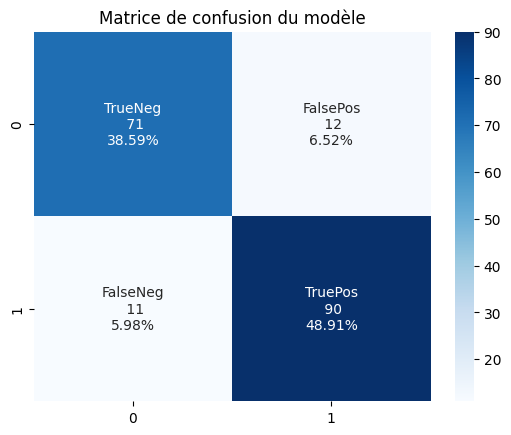

In [59]:
best_random_forest_estimator = forest.random_hyper_parameters_search(X_train, y_train, seed)
best_random_forest = foret_aleatoire(data, features_names=features_names, features_nbr=features_nbr, model = best_random_forest_estimator)
best_random_forest.evaluate_model(X_test,y_test)

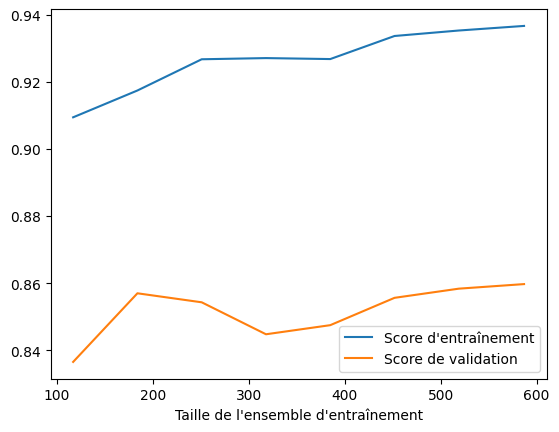

In [60]:
best_random_forest.plot_learning_curves(X_train, y_train, train_size)

Ces valeurs permettent d'établir des intervalles réduits pour un parcourt plus précis, cette fois à l'aide d'une grille exhaustive, en vue de la recherche des paramètres optimaux. En effet, une recherche aléatoire semble potentiellement moins performante.

Le score d'entrainement n'est plus constant égal à 1, ce qui signifie que le surapprentissage de l'ancien modèle a été réduit, mais il y a toujours une différence voyante entre la précision d'entrainement et celle de validation.

#### Recherche exhaustive
La recherche des hyperparamètres pour optimiser le modèle de forêt aléatoire est ensuite faite de manière exhaustive de manière plus précise, à l'aide des paramètres trouvés précédemment. Elle explore un espace défini d'hyperparamètres et utilise une validation croisée stratifiée pour évaluer la performance. Les meilleurs hyperparamètres déterminés et la précision associée au modèle optimal sont alors affichés.

La meilleure précision trouvée est de 0.8857142857142858 pour les hyperparamètres suivants : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 188}
Précision du modèle : 0.8858695652173914


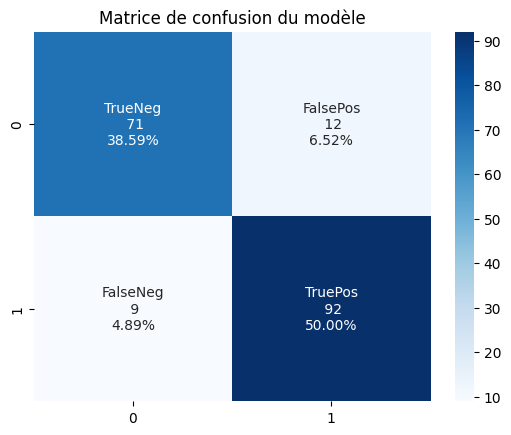

In [61]:
best_forest_estimator = forest.hyper_parameters_search(X_train, y_train, seed)
best_forest = foret_aleatoire(data, features_names=features_names, features_nbr=features_nbr, model = best_forest_estimator)
best_forest.evaluate_model(X_test,y_test)

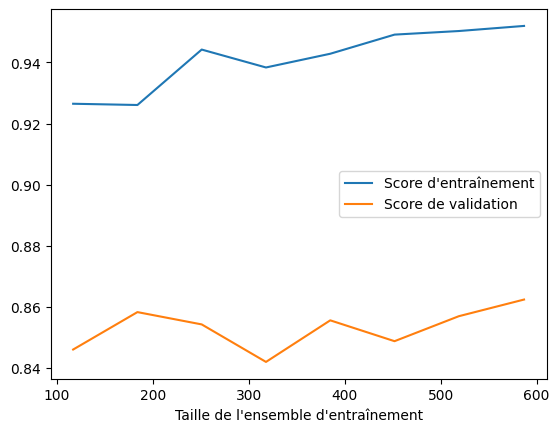

In [68]:
best_forest.plot_learning_curves(X_train, y_train, train_size)

Tel qu'observé, la précision du modèle augmente de manière minime, passant de 88.04% à 88.58%, avec 38.59% de vrais négatifs et 50.00% de vrais positifs. La recherche d'hyperparamètres optimaux semble avoir augmenté la précision en améliorant la prédiction des vrais positifs au détriment de la prédiction des vrais négatifs.

De même que précédemment, la courbe du score d'entrainement n'est plus constante égale à 1, ce qui signifie que le surapprentissage de l'ancien modèle a été réduit, mais l'écart entre la précision d'entrainement et celle de validation reste conséquente.

## 6 - Bayes gaussien naïf
Dans cette section, l'algorithme Bayes gaussien naïf repose sur le théorème de Bayes et suppose que les caractéristiques sont conditionnellement indépendantes, étant donné la classe de l'observation. En utilisant une distribution gaussienne pour modéliser les caractéristiques, il calcule la probabilité a posteriori de chaque classe pour une observation donnée, choisissant la classe avec la probabilité la plus élevée comme prédiction.

### Création d'une instance du modèle de forêt aléatoire
Nous commençons par créer une instance de la classe bayes_gaussien_naif, qui hérite des fonctionnalités de la classe abstraite Modele.

In [69]:
seed = 42
np.random.seed(seed)
# Création d'une instance du modèle de Bayes gaussien naïf
gnb = bayes_gaussien_naif(data=data, features_names=features_names, features_nbr=features_nbr, model=GaussianNB())

### Entrainement et évaluation du modèle
La normalisation n'est généralement pas nécessaire pour un Bayes gaussien naïf car cet algorithme est généralement peux affecté par les changements d'échelle. Toutefois, la standardisation pourrait être pertinente, puisqu'elle aide à respecter l'hypothèse de distribution gaussienne en centrant les données autour de zéro et en les mettant à l'échelle par l'écart-type, améliorant ainsi la cohérence des données avec les hypothèses de l'algorithme. Une fois standardisées, les données sont séparées pour créer les ensembles d'entrainement et de test.

In [70]:
# Récupération des ensembles d'entraînement et de validation
standardized_data = gnb.scale_data(features_to_normalise=[], features_to_standardise=features_names[:-1])
X_train, X_test, y_train, y_test = gnb.split_data(standardized_data)
print(standardized_data.head())
print(features_names)

        Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140  0.515952       0.229032   0.410909     0.825070  -0.551341   
1 -0.478484 -1.938163       1.275059   1.491752    -0.171961  -0.551341   
2 -1.751359  0.515952       0.229032  -0.129513     0.770188  -0.551341   
3 -0.584556 -1.938163      -0.816995   0.302825     0.139040  -0.551341   
4  0.051881  0.515952       1.275059   0.951331    -0.034755  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0    0.017255  1.382928       -0.823556 -0.832432  1.052114             0  
1    0.017255  0.754157       -0.823556  0.105664 -0.596078             1  
2    1.601219 -1.525138       -0.823556 -0.832432  1.052114             0  
3    0.017255 -1.132156        1.214246  0.574711 -0.596078             1  
4    0.017255 -0.581981       -0.823556 -0.832432  1.052114             0  
Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'Restin

Le modèle est alors entraîné à l'aide de l'ensemble d'entrainement, puis évalué à l'aide de l'ensemble de test.

Précision du modèle : 0.8369565217391305


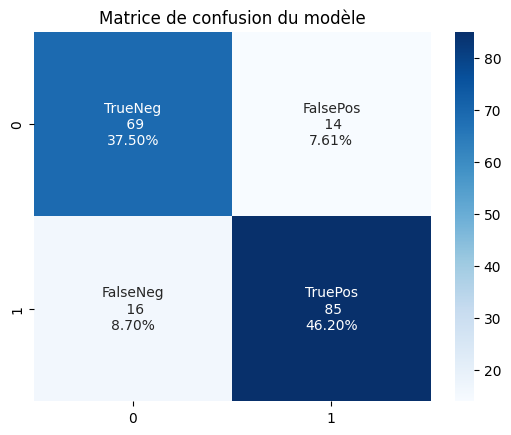

In [71]:
# Entraînement du modèle avec l'ensemble d'entraînement
gnb.train(X_train, y_train)
# Evaluation du modèle avec l'ensemble de test
gnb.evaluate_model(X_test,y_test)

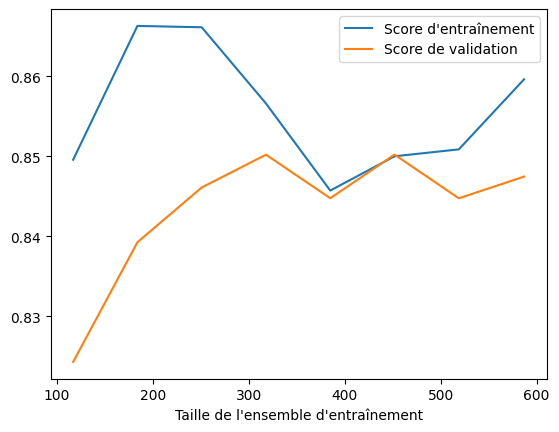

In [72]:
gnb.plot_learning_curves(X_train, y_train, train_size)

Les résultats obtenus sont également présentés sous la forme d'une matrice de confusion, qui permet de visualiser les prédictions correctes et incorrectes du modèle. L'algorithme de Bayes gaussien naïf permet donc d'obtenir une précision d'environ 83.70%, avec 37.50% de vrais négatifs et 46.20% de vrais positifs, ce qui présente également des résulats similaires aux algorithmes précédents : les vrais négatifs semblent légèrement plus difficiles à prédire.

Contrairement à la méthode précédente utilisant les forêts aléatoires, le cas présent semble présenter moins de surapprentissage lorsque la taille de l'ensemble d'entrainement augmente. L'objectif serait alors de trouver des hyperparamètres optimaux pour améliorer la précision finale, sans pour autant surapprendre.

### Recherches d'hyperparamètres optimaux
Les paramètres et hyperparamètres du modèles sont les suivants :

In [73]:
print(gnb.model.get_params())

{'priors': None, 'var_smoothing': 1e-09}


Le paramètre 'priors' concerne les cas d'utilisation où des connaissances a priori sur la distribution des classes sont disponibles, ce qui n'est pas le cas présent. La recherche d'hyperparamètres ne concerne donc que l'hyperparamètre 'var_smoothing' ici, qui contrôle la régularisation en ajoutant une certaine quantité à la variance des variables. Cela qui permet d'éviter des problèmes de calcul de probabilités conditionnelles lorsque certaines variances sont très proches de zéro. La valeur de var_smoothing devant être faible, un intervalle logarithmique entre 1e-9 et 1 est parcouru.

La meilleure précision trouvée est de 0.85578231292517 pour les hyperparamètres suivants : {'var_smoothing': 0.15199110829529336}
Précision du modèle : 0.842391304347826


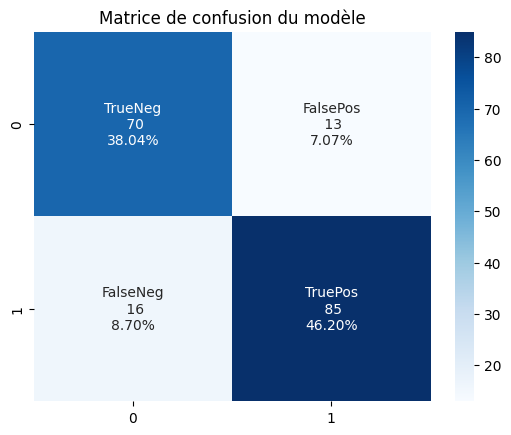

In [74]:
best_gnb_estimator = gnb.hyper_parameters_search(X_train, y_train, seed)
best_gnb = bayes_gaussien_naif(data, features_names=features_names, features_nbr=features_nbr, model=best_gnb_estimator)
best_gnb.evaluate_model(X_test, y_test)

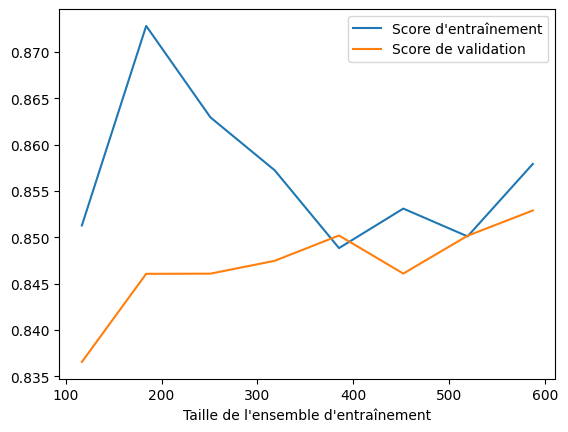

In [75]:
best_gnb.plot_learning_curves(X_train, y_train, train_size)

Tel qu'observé, la précision du modèle augmente de manière minime, passant de 83.70% à 84.24%, avec 38.04% de vrais négatifs et 46.20% de vrais positifs. La recherche d'hyperparamètres optimaux pour l'algorithme Bayes gaussien naïf a donc amélioré la prédiction des vrais négatifs, contrairement au cas de la structure de forêt d'arbres par exemple. Toutefois, elle présente une précision moindre.

La précision d'entrainement diminue drastiquement et plus rapidement que précédemment, tandis que le score de validation augmente légèrement.

## Conclusion
On récapitule dans le tableau ci-dessous l'ensemble des résultats obtenus pour chaque algorithme de classification.
| Classifieur            | Accuracy     |
|------------------------|--------------|
| Régression logistique  | 85%          |
| K plus proches voisins | 86%          |
| SVM                    | 84%          |
| Réseau de neurones     | 87%          |
| Forêt aléatoire        | 88%          |
| Bayes Gaussien naïf    | 84%          |

Ainsi, nos modèles ont une accuracy d'environ 85% ce qui est conforme aux résultats obtenus par d'autres équipes sur le même jeu de données [https://www.kaggle.com/code/kloseonejhp123/heart-failure-prediction-cv-score-90-5-models#Conclusion].

Nous avons résolu plusieurs problèmes techniques propres à la discipline au cours de ce projet:
- Traitement des données catégoriques : encodage des données
- Pré-traitement des données : visualisation, normalisation et standardisation
- Implémentation d'algorithmes de classification prédisant correctement les résultats
- Recherche d'hyper paramètres
- Etudes de l'overfitting
- Utilisation de cross-validation

Nous envisageons les améliorations suivantes pour un nouveau projet:
- Pré-traitement des données : détection des outliers, utilisation de matrice de corrélation pour déterminer les features caractéristiques du problème
- Utilisation du Bagging / Boosting
- Correction des problèmes d'overfitting

Finalement, nous avons pu mettre en place des modèles relativement bons permettant de répondre au problème de classification concret que nous avons choisi.
